<a href="https://colab.research.google.com/github/RohanMathur17/Scream_Detection/blob/main/Scream_Detection_DataAug_Librosa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!pip install -q pydub

In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Input, Lambda, Conv2D, BatchNormalization
from tensorflow.keras.layers import Activation, MaxPool2D, Flatten, Dropout, Dense
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.optimizers import Adam
from sklearn import metrics
from IPython.display import Audio
from matplotlib import pyplot as plt
from tqdm import tqdm
import os
import numpy as np
from scipy.io import wavfile 
import librosa
import random
import pydub
import librosa.display

In [4]:
def absolute_file_paths(directory): #setting path
    path = os.path.abspath(directory)
    return [entry.path for entry in os.scandir(path) if entry.is_file()]

scream_paths = absolute_file_paths('/content/gdrive/MyDrive/Scream Data/positive')
non_scream_paths = absolute_file_paths('/content/gdrive/MyDrive/Scream Data/negative')
atmospheric_paths = absolute_file_paths('/content/gdrive/MyDrive/Scream Data/atmospheric_sounds')

In [5]:
all_paths = []
all_labels = []

for scream in scream_paths:
    label = 'scream'
    all_paths.append(scream)
    all_labels.append(label)

for non_scream in non_scream_paths:
    label = 'non_scream'
    all_paths.append(non_scream)
    all_labels.append(label)

for atmos in atmospheric_paths:
    label = 'atmospheric'
    all_paths.append(atmos)
    all_labels.append(label)

In [6]:
lb = LabelBinarizer()
labels = lb.fit_transform(all_labels)
labels.shape

(211, 3)

In [7]:
### Train Test Split
X_train,X_test,y_train,y_test=train_test_split(all_paths ,labels ,test_size=0.3,random_state=0)

In [8]:
print(len(X_train))
print(len(X_test))
print(len(y_train))
print(len(y_test))

147
64
147
64


In [9]:
def get_signal(file_name):
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
    return audio, sample_rate

X_train_signal = []
for audio in X_train:
    signal , sr =  get_signal(audio)
    X_train_signal.append([signal, sr])
    

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


In [10]:
def data_aug(signal, sample_rate):

    noise_factor = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35]
    stretch_rate = [0.6, 0.65, 0.7, 0.75, 0.8]
    num_semitones = [-2,-1, 0, 1, 2]

    noise = np.random.normal(0,signal.std(), signal.size)  # Noise vector created using Gaussian Distribution

    augmented_1 =  signal + noise * random.choice(noise_factor)

    augmented_2 =  librosa.effects.time_stretch(augmented_1, random.choice(stretch_rate))

    augmented_3 =  librosa.effects.pitch_shift(augmented_2 , sample_rate , random.choice(num_semitones))

    return augmented_3, sample_rate

augmented_signals = []
for signals in X_train_signal:

    signal = signals[0]
    sample_rate = signals[1]
    augmented_signal, sample_rate = data_aug(signal, sample_rate)
    augmented_signals.append([augmented_signal, sample_rate])

In [11]:
augmented_signals = np.asarray(augmented_signals)
X_train_signal   = np.asarray(X_train_signal)

print(augmented_signals.shape)
print(X_train_signal.shape)

new_X_train = np.concatenate((augmented_signals, X_train_signal), axis=0)
print(new_X_train.shape)

(147, 2)
(147, 2)
(294, 2)


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [12]:
y_train_1 = np.copy(y_train)
new_y_train = np.concatenate((y_train, y_train_1), axis=0)

print(new_y_train.shape)

(294, 3)


In [13]:
def features_extractor(audio, sample_rate):
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40) #spectogram? feature engineering for audio
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0) #scaling, mean , standardization?
    
    return mfccs_scaled_features

X_train_features = []
for x in new_X_train:
    #new_X_train_features = features_extractor()
    audio = x[0]
    sample_rate = x[1]
    mfccs_scaled_features = features_extractor(audio, sample_rate)
    X_train_features.append(mfccs_scaled_features)

In [14]:
X_train_features = np.asarray(X_train_features)
X_train_features.shape

(294, 40)

In [15]:
def features_extractor_test(file_name):
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') #loading audio files, #sample rate- numerical int value of each music file
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40) #spectogram? feature engineering for audio
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0) #scaling, mean , standardization?
    
    return mfccs_scaled_features

X_test_features = []
for x in X_test:
    data = features_extractor_test(x)
    X_test_features.append(data)

X_test_features = np.asarray(X_test_features)
X_test_features.shape

(64, 40)

In [16]:
print(X_train_features.shape)
print(new_y_train.shape)
print(X_test_features.shape)
print(y_test.shape)

(294, 40)
(294, 3)
(64, 40)
(64, 3)


In [17]:
num_labels = y_test.shape[1]

In [18]:
model=Sequential() 
###first layer
model.add(Dense(100,input_shape=(40,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###second layer
model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###third layer
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.5))

###final layer
model.add(Dense(num_labels))
model.add(Activation('softmax'))

In [19]:
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

In [20]:
## Trianing my model
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime 

num_epochs = 100
num_batch_size = 32

checkpointer = ModelCheckpoint(filepath='saved_models/audio_classification.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

history = model.fit(X_train_features, new_y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test_features, y_test), callbacks=[checkpointer],
          verbose=1, shuffle = True)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/100
 1/10 [==>...........................] - ETA: 19s - loss: 25.1838 - accuracy: 0.3750
Epoch 00001: val_loss improved from inf to 9.26968, saving model to saved_models/audio_classification.hdf5
10/10 [==============================] - 2s 34ms/step - loss: 26.3995 - accuracy: 0.3231 - val_loss: 9.2697 - val_accuracy: 0.4844
Epoch 2/100
 1/10 [==>...........................] - ETA: 0s - loss: 19.7919 - accuracy: 0.3750
Epoch 00002: val_loss improved from 9.26968 to 1.74483, saving model to saved_models/audio_classification.hdf5
10/10 [==============================] - 0s 10ms/step - loss: 18.1032 - accuracy: 0.3605 - val_loss: 1.7448 - val_accuracy: 0.7812
Epoch 3/100
 1/10 [==>...........................] - ETA: 0s - loss: 13.5589 - accuracy: 0.4688
Epoch 00003: val_loss improved from 1.74483 to 1.33522, saving model to saved_models/audio_classification.hdf5
10/10 [==============================] - 0s 13ms/step - loss: 11.6107 - accuracy: 0.4864 - val_loss: 1.3352 - val_accura

In [21]:
test_accuracy=model.evaluate(X_test_features,y_test,verbose=0)
print(test_accuracy)

[0.59354168176651, 0.953125]


In [22]:
predictions = model.predict(x=X_test_features)
print(classification_report(y_test.argmax(axis=1),
	predictions.argmax(axis=1), target_names=lb.classes_))

              precision    recall  f1-score   support

 atmospheric       1.00      1.00      1.00        16
  non_scream       0.91      0.95      0.93        22
      scream       0.96      0.92      0.94        26

    accuracy                           0.95        64
   macro avg       0.96      0.96      0.96        64
weighted avg       0.95      0.95      0.95        64



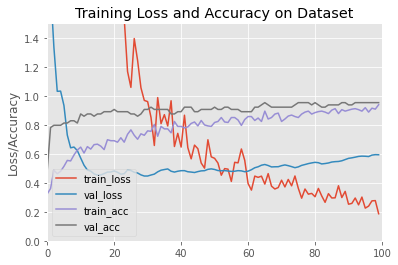

In [23]:
N = 100
plt.style.use("ggplot")

plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.ylim(0,1.5)
plt.xlim(0,100)
plt.title("Training Loss and Accuracy on Dataset")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
#plotPath = r'E:\Rohan\Sem 7\Minor Project\Major Project\Model'
plt.show()